In [1]:
#Importing all libraries and dependecies 
import numpy as np
import matplotlib.pyplot as plt
import gym 
import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
class DQN:
    def __init__(self,env):
        self.env = env  # Environment 
        self.gamma = 0.99# Discount factor  
        self.batch_size = 64 # Batch_size 
        self.memory = deque(maxlen= 10000) #Memory 
        self.memory_size = 1000 # 
        self.state_size = env.observation_space.shape[0] # State size 
        self.action_size = env.action_space.n # action shape
        self.learning_rate = 0.001 # Learing rate 
        self.episilon = 1.0 # Episilon for greedy strategy
        self.episilon_min = 0.005 # Minimum value of episilon
        self.decay = (self.episilon - self.episilon_min)/50000  # Decay_rate
        self.policy = self.Create_model() # Policy Network
        self.target_Net = self.Create_model() # Target Network
        
    def Create_model(self): #creating a Neural Network
        model = Sequential()
        model.add(Dense(24, activation = 'relu'))
        model.add(Dense(self.action_size, activation = 'linear'))
        model.compile(loss = 'mse', optimizer = Adam(lr = self.learning_rate))
        return model
    
    #Episilon-Greedy Strategy
    def act(self,state):
        if np.random.random() < self.episilon:
            action = self.env.action_space.sample()
        else:
            action = np.argmax(self.policy.predict(state)[0])
            
        if self.episilon > self.episilon_min:
            self.episilon -= self.decay
        return action
    
    #Adding Experience 
    def remember(self, state, action, reward, next_state, done):
        self.memory.append([state, action, reward, next_state, done])
    
    # Replay function
    def replay(self):
        if len(self.memory) < self.memory_size:
            return
        mini_batch = random.sample(self.memory, self.batch_size)
        state_input = np.zeros((self.batch_size, self.state_size))
        target_output = np.zeros((self.batch_size, self.action_size))
            
        for i in range(self.batch_size):
            state, action, reward, next_state,done = mini_batch[i]
            target = self.policy.predict(state)[0]
            if done:
                target[action]  = reward
            else:
                target[action] = reward + self.gamma*np.amax(self.target_Net.predict(next_state)[0])
                    
            state_input[i] = state
            target_output[i] = target
                
        self.policy.fit(state_input, target_output, batch_size = self.batch_size, epochs = 1, verbose = 0)
        
    # Updating the target net with policy network weights        
    def target_train(self):
            self.target_Net.set_weights(self.policy.get_weights())
            return
    #Saving the trained model     
    def save(self,model_name, model_weight):
        self.policy.save(model_name)
        self.policy.save_weights(model_weight)

In [4]:
#Initializing the environment 
env = gym.make("MountainCar-v0")

#state_size
state_size = env.observation_space.shape[0] 
#number of time_step for each episode
steps = 200

#Number of episode for the episodic task
episode = 2000

#Empty list for keeping track of reward for each episodes 
reward_list =[]
rewards = []

#Empty list for keeping track of the average reward over 100 episodes 

ave_reward_list = []

#Initializing the Deep Q_network agent
dqn_agent= DQN(env)

# Iterating over each episode 
for e in range(episode):
    current_state = env.reset().reshape(1,state_size)
    reward_sum  = 0
    #Training for each time-step
    for _ in range(steps):
        if e >= (episode -20): # rendering the environment for the last five episodes 
            env.render()
        action = dqn_agent.act(current_state) # Best action using episilon-greedy strategy
        
        next_state, reward, done, info = env.step(action) # processing the action
        
        next_state = next_state.reshape(1, state_size) # reshaping for the neural network
        
        dqn_agent.remember(current_state, action, reward, next_state, done) # Adding the experience to the memory batch
        
        dqn_agent.replay() # Replaying a sample batch from the Experience memory 
        
        #Tracking the Reward for each episode
        reward_sum += reward
        
        #initializing the current_state for the next time_step
        current_state = next_state
        
        if done:
            dqn_agent.target_train() #if the episode is done get the weights of the policy_net to update the target_net
            break
        
    # append the total reward of each episode to the list
    reward_list.append(reward_sum)
    rewards.append(reward_sum)
    
    #computing the average Reward over 100 episodes 
    if (e+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            print("Episode {} Average Reward: {}".format(e+1, ave_reward))
            reward_list = [] # Returning an empty list for the next 100 episodes
dqn_agent.save('TrainedModelMountainCar.h5', 'TrainedModelMountainCar_weights')
#End the game            
env.close()

Episode 100 Average Reward: -200.0
Episode 200 Average Reward: -200.0
Episode 300 Average Reward: -200.0
Episode 400 Average Reward: -200.0
Episode 500 Average Reward: -199.52
Episode 600 Average Reward: -200.0
Episode 700 Average Reward: -200.0
Episode 800 Average Reward: -200.0
Episode 900 Average Reward: -199.56
Episode 1000 Average Reward: -191.89
Episode 1100 Average Reward: -183.16
Episode 1200 Average Reward: -171.81
Episode 1300 Average Reward: -143.24
Episode 1400 Average Reward: -126.36
Episode 1500 Average Reward: -126.71
Episode 1600 Average Reward: -135.94
Episode 1700 Average Reward: -139.82
Episode 1800 Average Reward: -142.73
Episode 1900 Average Reward: -138.64
Episode 2000 Average Reward: -153.0


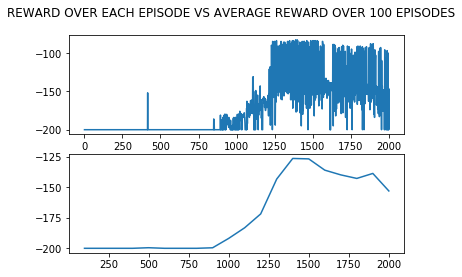

In [8]:
fig,(ax1,ax2) = plt.subplots(2)
fig.suptitle('REWARD OVER EACH EPISODE VS AVERAGE REWARD OVER 100 EPISODES')
ax1.plot(range(1,len(rewards)+1), rewards, label = 'Reward of each episode')
ax2.plot(100*(np.arange(len(ave_reward_list)) +1),ave_reward_list, label = 'Average Reward over 100 episodes')

In [1]:
import gym 
import numpy as np
from keras import models
import os
from gym import wrappers
env = gym.make('MountainCar-v0')

Using TensorFlow backend.


In [2]:
model = models.load_model('TrainedModelMountainCar.h5')

#model1 = model1.load_weights('TrainedModelMountainCar_weights')

In [ ]:
#Testing the model on the environment
state_size = env.observation_space.shape[0]
#env = wrappers.Monitor(env, os.path.join(os.getcwd(), "Videos"), force =True)
for e in range(10):
    current_state = env.reset().reshape(1,state_size)
    print('==================================================')
    reward_sum= 0
    for t in range(200):
        env.render()
        action = np.argmax(model.predict(current_state)[0])
        new_state,reward,done,_ = env.step(action)
        reward_sum += reward
        new_state = new_state.reshape(1,state_size)
        current_state = new_state
        
        if done:
            print("Episode{} finished after {} time_step with a reward {}".format(e+1, t+1, reward_sum))
            break          
env.close()

Episode1 finished after 151 time_step with a reward -151.0
Episode2 finished after 146 time_step with a reward -146.0
Episode3 finished after 148 time_step with a reward -148.0
Episode4 finished after 153 time_step with a reward -153.0
Episode5 finished after 150 time_step with a reward -150.0


In [ ]:
for e in range(1000):
    env.reset()
    env.render()
    action = env.action_space.sample()
env.close()